<img src="logoD.png" alt="Logo MUII" align="right">

<br><br>
<a id="principio"></a> 
## Práctica 4 (II)

# Agrupamiento de películas con k-means


<br>
<div style="text-align: right">
Luis de la Ossa
<br>
Master Universitario en Ingeniería Informática
<br>
Universidad de Castilla-La Mancha

</div>

<br>

---

<br>
En esta libreta se aplicará el algoritmo _k-medias_ para agrupar un conjunto de 45843 películas. Para ello, se dispone de una representación vectorial de cada una, denominada "genoma", que representa el grado en que presenta ciertas características, y que permite cuantificar la similaridad. 


<br>
Los clusters obtenidos pueden ser la base de un sencillo sistema de recomendación (se verán sistemas de recomendación en el próximo módulo), en el que se determine qué tipo de películas son las preferidas por un usuario, y se le recomienden películas del mismo grupo.

In [1]:
# Permite ensanchar el área útil de la libreta
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

---

## 1. La base de datos de películas _MovieLens_ 

<br>
[MovieLens](https://movielens.org/) es una web creada por el grupo [GroupLens](https://grouplens.org/) de la Universidad de Michigan para la investigación en sistemas de recomendación. La plataforma hace las recomendaciones a cada usuario a partir de información que éste proporciona previamente. Esta información es utilizada, a su vez, para alimentar el propio sistema. 

El conjunto de datos `datos/movies.csv` contiene los identificadores y títulos de las 45000 películas incluídas hasta agosto de 2017.

__Nota__: Estos identificadores son independientes de los usados en _IMDb_ o _TMDb_, aunque existe un conjunto de datos con las correspondencias. 

In [2]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv("datos/movies.csv", sep=',')
df_movies.set_index('movieId', inplace=True)
# Muestra las dos primeras y las dos últimas
display(df_movies.iloc[[0,1, -2,-1]])
# Número de películas (no siguen una secuencia)
print("Número de películas: ",len(df_movies))

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
176275,Satan Triumphant (1917)
176279,Queerama (2017)


Número de películas:  45843


---

###  El "genoma" de una película 

<br>
Con el fin caracterizar las películas, se ha creado un conjunto de 1128 etiquetas o palabras clave. Mediante un algoritmo de aprendizaje automático ([enlace](http://files.grouplens.org/papers/tag_genome.pdf)) que toma como entrada contenido elaborado por usuarios -etiquetas, revisiones, etc-  se ha calculado el _score_ o relevancia de cada etiqueta con respecto a cada película. El archivo `datos/genome-tags.csv` contiene las etiquetas y su identificador.

<br>
__Nota__: Los identificadores las etiquetas siguen una secuencia de 1 a 1128. Para facilitar la indexación en el trabajo posterior se desplazan las etiquetas, restando uno, de modo que esta secuencia comience en 0, y pueda accederse por posición.

In [3]:
df_tags = pd.read_csv('datos/genome-tags.csv',sep=',')
# Se indexa desde cero
df_tags['tagId']=df_tags['tagId']-1             
df_tags.set_index('tagId', inplace=True)
df_tags.head()

,tag
tagId,
0,007
1,007 (series)
2,18th century
3,1920s
4,1930s



<br>
El archivo `datos/genome-scores.csv` contiene los datos sobre el "genoma" para cada película. Igual que en el caso anterior, se modificarán los indentificadores de las etiquetas para que la secuencia de índices comience en cero.

In [4]:
# Lee el conjunto de datos
df_genome = pd.read_csv('datos/genome-scores.csv',sep=',')
# Resta uno a los identificadores de la etiqueta
df_genome['tagId'] = df_genome['tagId'] - 1 
df_genome.head()

,movieId,tagId,relevance
0,1,0,0.02475
1,1,1,0.02475
2,1,2,0.04900
3,1,3,0.07750
4,1,4,0.12450


<br>
Cada entrada del conjunto de datos `df_genome` corresponde a la relevancia de un par película/etiqueta. Es posible transformar la tabla de modo que cada fila contenga los datos relativos a una película (**cada columna representa una etiqueta**) mediante las funciones `DataFrame.pivot_table()` o `DataFrame.unstack()`. En el caso de la segunda, es necesario primero crear un índice jerárquico en el que el primer nivel corresponde al indentificador de la película, y el segundo al identificador de las etiquetas. 

In [5]:
df_genome = pd.pivot_table(df_genome, index=['movieId'], columns='tagId')

# Muestra la primera y última fila
df_genome.iloc[[0,-1]]

relevance                                                      \
tagId        0        1      2        3        4        5        6      
movieId                                                                 
1         0.02475  0.02475  0.049  0.07750  0.12450  0.23875  0.06575   
174585    0.09675  0.07475  0.030  0.03375  0.09275  0.01850  0.03200   

                                     ...                               \
tagId       7        8        9      ...        1118    1119     1120   
movieId                              ...                                
1        0.28575  0.25400  0.02625   ...     0.03125  0.0205  0.04300   
174585   0.08125  0.06375  0.02250   ...     0.04900  0.1010  0.03925   

                                                                      
tagId       1121     1122    1123     1124    1125     1126     1127  
movieId                                                               
1        0.03375  0.12375  0.0415  0.02125  0.0360  0.10425  0.02750  
174585   0.01675  0.41250  0.0775  0.06575  0.0205  0.11775  0.01475  

[2 rows x 1128 columns]

<br>
La siguiente celda de código muestra las etiquetas más relevantes (con _score_ más alto) para la primera película del conjunto de datos, "_Toy Story_". Para ello, se extraen los identificadores del `DataFrame` `df_genome`, y posteriormente se obtienen las etiquetas de `df_tags`.

In [6]:
print("Título: "+format(df_movies.iloc[0]['title'])+"\n")
print("Etiquetas más relevantes: ")

#Cogemos las columnas de la serie de Id = 1, ordenamos de mayor a menor y cogemos los 20 primeros valores
first_movie_tags = df_genome.loc[1].sort_values(ascending=False)[:20]
#El tag Id de estas columnas está en first_movie_tags.index.labels[1]
df_tags.loc[first_movie_tags.index.labels[1]]

Título: Toy Story (1995)

Etiquetas más relevantes: 


,tag
tagId,
1035,toys
243,computer animation
785,pixar animation
588,kids and family
63,animation
587,kids
203,children
784,pixar
185,cartoon


---

## 2. Agrupación de películas por similaridad 

<br>
El "genoma" permite representar cada película mediante un vector. Es posible calcular la similaridad entre pares de películas utilizando una medida de distancia; en este caso, la euclídea. La función `pairwise_distances` del módulo `sklearn.metrics` toma como entrada dos arrays bidimensionales, y calcula las distancias entre elementos de la primera y la segunda. 

En esta celda se obtienen las diez películas más cercanas a "_Toy Story_" y se muestran sus títulos. Para ello, se pasa a `pairwise_distances` el conjunto de valores en `df_genomes`, como primer argumento, y una matriz que contiene solo un vector, el "genoma", de "_Toy Story_", como segundo. 

In [7]:
from sklearn.metrics import pairwise_distances

# Obtiene las distancias a Toy Story. Se devuelve un array de arrays, cada array conteniendo un elemento
# Se utiliza reshape para eliminar esa segunda dimension innecesaria
distances_ts = pairwise_distances(df_genome, [df_genome.loc[1]]).reshape(10993)
distances_ts

array([3.37174788e-07, 5.47665777e+00, 6.27507040e+00, ...,
       8.59654608e+00, 8.20075818e+00, 7.90111213e+00])

In [8]:
# Ordenamos una copia y quitamos los 10 primeros elementos (sin contar el primero)
distances_ts_ordered = distances_ts.copy()
distances_ts_ordered.sort()
distances_ts_short = distances_ts_ordered[1:11]
distances_ts_short

array([2.45470292, 2.60811841, 2.73998074, 3.48898876, 3.51273301,
       3.55348033, 3.56017649, 3.73320671, 3.76221624, 3.94517923])

In [9]:
# Obtenemos los indices que ocupan esas peliculas mas cercanas a la indicada en df_genoma
indices = np.where(np.isin(distances_ts, distances_ts_short))
# Usamos el movieId asociado a cada indice de df_genome para encontrar las peliculas que son
df_movies.loc[df_genome.iloc[indices].index]

,title
movieId,
2355,"Bug's Life, A (1998)"
3114,Toy Story 2 (1999)
4306,Shrek (2001)
4886,"Monsters, Inc. (2001)"
5218,Ice Age (2002)
6377,Finding Nemo (2003)
42191,Luxo Jr. (1986)
50872,Ratatouille (2007)
78499,Toy Story 3 (2010)


<br>

La existencia de una medida de similaridad entre películas permite utilizar el algorimto _k-means_ para construir grupos. En la siguiente celda, se utilizará esta información para categorizar las películas en (por ejemplo) 15 grupos. 

In [10]:
from sklearn.cluster import KMeans

k = 15
X = df_genome
# Utilizamos como inicialización 'k-means++', que suele dar mejores resultados. 
km = KMeans(n_clusters=k, init='k-means++')
km.fit(X)

# Centroides
centroids = km.cluster_centers_
print("Centroides:")
print(centroids)
print()

# Clusters
clusters = km.labels_
print("Clusters (para los 20 primeros puntos:")
print(clusters[:20])

Centroides:
[[0.05231347 0.04661146 0.03484598 ... 0.01341912 0.09271749 0.01949574]
 [0.02822462 0.03040423 0.07579654 ... 0.04771692 0.07984385 0.02220192]
 [0.03489856 0.03696149 0.05689546 ... 0.0208315  0.1032837  0.03253817]
 ...
 [0.02485916 0.02665937 0.09736489 ... 0.03628807 0.07764825 0.02339488]
 [0.0683095  0.0561745  0.048803   ... 0.019419   0.0829795  0.0224055 ]
 [0.03199774 0.03199811 0.03699095 ... 0.01261161 0.34013876 0.1348635 ]]

Clusters (para los 20 primeros puntos:
[10 10  5  8  8  6  8  5  9  9  8  0 10  7  9  6  3  2  0  5]


Como resultado del proceso de agrupamiento se devuelven:

* El centroide de cada cluster, que corresponde a un vector con la relevancia media de las películas del cluster con respecto a cada etiqueta. 
* El índice del cluster al que se ha asignado cada película. 
<br>

---

###   Descripción de cada grupo  

<br>
En muchas situaciones, el paso posterior al proceso de clustering consiste en elaborar una descripción de los elementos que pertenecen a cada grupo. En el caso de _k-means_, ésta viene dada, en parte, por el centroide. En este contexto, el centroide representa la relevancia media de cada etiqueta para las películas que corresponden a un grupo.  Las etiquetas con mayor valor, que son las más importantes, permiten determinar qué tipo de películas corresponden a un grupo determinado.  

En esta celda se muestran las 20 etiquetas con más peso para el primer grupo (por ejemplo).

In [11]:
# Extrae los centroides
k_centers = km.cluster_centers_

# Extrae el centroide de un cluster, por ejemplo el primero.
sel_cluster = 0
centroid = k_centers[sel_cluster]
print("Centroide :"+str(centroid))
# Extrae las 30 etiquetas con más score y las muestra
#Negamos el array para que se ordene en orden descendente y volvemos a negar para dejarlo positivo
ord_tags = -np.sort(-centroid)[:30]
print("Relevancias más altas del centroide (30) :\n"+str(ord_tags))
#Buscamos las posiciones de esas 30 tags mas influyentes
cluster_tags = df_tags.loc[np.where(np.isin(centroid, ord_tags))]
cluster_tags

Centroide :[0.05231347 0.04661146 0.03484598 ... 0.01341912 0.09271749 0.01949574]
Relevancias más altas del centroide (30) :
[0.8769942  0.73623568 0.73599884 0.66867144 0.6567589  0.64844969
 0.56278599 0.54826548 0.53044195 0.50415673 0.49871904 0.47802206
 0.47002167 0.46825077 0.46757663 0.45307624 0.4518065  0.44926741
 0.44921865 0.44031463 0.43314087 0.43187771 0.42491563 0.41949342
 0.41675387 0.41300658 0.40737964 0.40225193 0.39682508 0.39517454]


,tag
tagId,
17,absurd
187,catastrophe
194,chase
229,comedy
271,crude humor
301,dialogue
332,dumb but funny
414,fun movie
415,funniest movies


---

Es posible mostrar las etiquetas de un modo más original, mediante una nube de palabras.

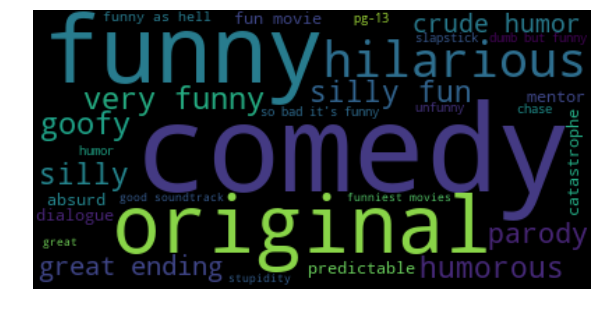

In [12]:
# Extrae las etiquetas
text = cluster_tags['tag'].values
# Extrae los scores
id_tags = cluster_tags.index
scores = centroid[id_tags]

# Muestra una nube de palabras
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crea un diccionario con las palabras y sus scores (como enteros)
scores = (scores*100).astype(np.int)
tag_scores = dict(zip(text,scores))

# Genera la nube de palabras
wordcloud = WordCloud().generate_from_frequencies(tag_scores)

# La muestra
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

---

###  Elementos en cada cluster 

<br>
Una vez hechos y caracterizados los grupos, es posible acceder a las películas que los forman. Para ello, es necesario extraer primero los identificadores, y posteriormente acceder al `DataFrame` `df_movies`.

In [13]:
# Obtiene las etiquetas para cada caso
clusters = km.labels_

# Obtiene las películas (posiciones) correspondientes al primer cluster
movies_sel_cluster = df_genome.iloc[np.where(clusters == 0)]

# Obtiene los identificadores de las películas
id_movies = movies_sel_cluster.index

# Muestra los diez primeros
df_movies.loc[id_movies].head(10)

,title
movieId,
12,Dracula: Dead and Loving It (1995)
19,Ace Ventura: When Nature Calls (1995)
63,Don't Be a Menace to South Central While Drink...
65,Bio-Dome (1996)
69,Friday (1995)
88,Black Sheep (1996)
102,Mr. Wrong (1996)
104,Happy Gilmore (1996)
122,Boomerang (1992)


---

###  Coste/k 

<br>
El número de grupos en el que se han dividido las películas en el ejemplo, 15, se ha establecido de manera arbitraria. La curva coste/k puede ayudar a establecer este grupo. Para ello, es necesario primero implementar la función de coste.

In [14]:
def cost(data, k, centroids, clusters):
    cost = 0.0
    for c in range(k):
        points_cluster = data[clusters==c, :]
        if points_cluster.shape[0] > 0: 
            distances = pairwise_distances(points_cluster, [centroids[c]], metric='euclidean')
            cost += np.sum(distances**2)
    return cost

<br>

Para estimar el número adecuado de clusters en función del coste, es necesario repetir el proceso para un rango de valores de $k$. Como se ha visto anteriormente, la ejecución de `Kmeans` sobre el conjunto de datos `df_genome` requiere varios segundos.  En la práctica anterior se recurrió al muestreo para acelerar el algoritmo. Otra posibilidad consiste en utilizar, en lugar de `Kmeans` la versión `MiniBatchKMeans`.

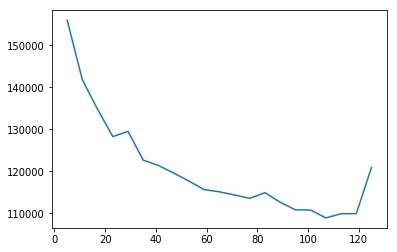

In [15]:
from sklearn.cluster import MiniBatchKMeans

# Guarda los costes
costs = np.zeros(21,)
# Valores de k de 1 a 64
ks = np.linspace(5,125,21).astype(int)

# Ejecuta k-means para cada valor de k, y guarda el coste asociado
for i,k in enumerate(ks):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=500)    
    kmeans.fit(df_genome.values)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.labels_
    costs[i] = cost(df_genome.values, k, centroids, clusters)
    
plt.plot(ks,costs);    

<br> 

Puede observarse que el cambio de tendencia no es tan acusado como en la práctica anterior, por lo que es más difícil determinar cual es el valor óptimo, ya que este debería estar en un punto entre 20 y 100.

<br>
En este caso, y en otros muchos, esta elección puede no seguir un criterio estrictamente numérico. Por ejemplo, si se utilizan 100 grupos, estos son más específicos. Sin embargo, puede ser que en un determinado contexto, esta división sea excesiva. 

In [16]:
# Crea el objeto k-means
km = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=500, random_state=0)
# Ejecuta k-means sobre el cojunto de datos df_genome
km.fit(df_genome)
# COMPLETAR

# Extrae los centroides
k_centers = km.cluster_centers_

In [17]:
# Extrae el centroide de un cluster, por ejemplo el primero.
sel_cluster = 0
centroid = k_centers[sel_cluster]
print("Centroide :"+str(centroid))

# Extrae las 30 etiquetas con más score y las muestra
ord_tags = -np.sort(-centroid)[:30]
cluster_tags = df_tags.loc[np.where(np.isin(centroid, ord_tags))]
cluster_tags

Centroide :[0.03492539 0.03414267 0.03708377 ... 0.00810079 0.23086257 0.05186518]


,tag
tagId,
98,bad ending
99,bad plot
187,catastrophe
266,creepy
291,death
293,demons
301,dialogue
343,eerie
395,first contact


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#990003"></i> </font></div>